In [1]:
using Plots

In [2]:
function get_moore_neighbors(i,j,grid)
    """
    return the  values of the moore neighborhood of a given cell at location i,j
    inputs:
        i<int>: the x index of the cell we want to pick 
        j<int>: the y index of the cell we want to pick 
        grid<NxN matrix>: the actual state of the celluar automata, we will pick the grid[i,j] to be the cell we look at
    returns: 
        neighbors<matrix>: an 2d matrix of the values of the 8 cells in the Moore neighborhood of cell i,j
    """
    values = [mod1.(x .+ [-1,0,1], size(grid)[1]) for x in 1:length(grid)]
    neighbors = grid[values[i],values[j]]
end

function get_von_neumann_neighbors(i,j,grid)
    """
    return the  values of the von neuman neighborhood of a given cell at location i,j
    inputs:
        i<int>: the x index of the cell we want to pick 
        j<int>: the y index of the cell we want to pick 
        grid<NxN matrix>: the actual state of the celluar automata, we will pick the grid[i,j] to be the cell we look at
    returns: 
        neighbors<array>: an array of the values of the 4 cells in the von neuman neighborhood of cell i,j
    """
    values = [mod1.(x .+ [-1,0,1], size(grid)[1]) for x in 1:length(grid)]
     values_i = grid[i,values[j]]
     values_j = grid[values[i],j]
     return cat(values_i,values_j)
end

function game_of_life_update(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 1 < alive_neighbors < 4 #if the number of alive_neighbors is equal to 2 or 3, the cel remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors == 3
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end

### This cell sets up the Moore and von Neumann Neighborhoods and also the original game of life rules

game_of_life_update (generic function with 1 method)

In [3]:
function run_ca_simulation(grid_0,update_func ,num_generations)
    """
    takes in an initial callular automota state, an updating rule and run a CA simulation for <num_generations>
    inputs: 
        grid_0<NxN martrix>: an NxN matrix which is the inital state of the CA
        update_func<function> this is the function, like <game_of_life_update> that will determine how the CA is updated
        num_generations<int>: the number of generations of the model to run
    returns: 
        grid_history<NxNxnum_generations matrix>: this is a matrix where every NxN 2d slice is the state of the CA at one time step. The entire 3d matrix stores the history of the ca_gif
    """
    N = size(grid_0)[1]
    grid_history = zeros(Int8,N,N,num_gens)
    grid_history[:,:,1] = grid_0#the first entry in our grid history will be the inital conditions
    grid = grid_0 

    for gen in 2:num_gens#for each generation
        next_grid =zeros(Int8,N,N) #create a new grid
        for (i,j) in Tuple.(CartesianIndices(grid))#for each cell in the gird
            neighborhood = get_moore_neighbors(i,j,grid)#get the neighborhood of that cell
            #println(neighborhood)
            next_grid[i,j] = update_func(neighborhood)#calculate the state of cell i,j based on the updating rule
        end
        grid_history[:,:,gen] = next_grid#save in the history
        grid = next_grid
    end
    return grid_history
end

### This cell runs the CA model and returns a 3-d matrix where a slice is a snapshot of the CA at that time
### and this 3-d matrix can and is made into a gif

run_ca_simulation (generic function with 1 method)

In [4]:
function plot_ca(grid_history,file_name,fps =8)
    """
    Takes in a NxNxnum_gens 3d array of grid histories and creates an animation 
    inputs:
        grid_history<matrix>: this is a matrix where every NxN 2d slice is the state of the CA at one time step. The entire 3d matrix stores the history of the ca_gif
        file_name<string>: the resulting animation will be saved as a gif with this file name 
    output:
        ca_fig<gif>: returns the sequence of CA generations as an animated gif. 
    """
    num_gens = size(grid_history)[3]#get the number of frames from the size of the matrix, one frame per generation
    anim = @animate for frame in 1:num_gens#create a heatmap for each frame of the animation
        heatmap(grid_history[:,:,frame],xaxis = false,yaxis=false,legend = false,ticks=false,background_color_outside = "black",figsize = (15,15))
    end
    ca_gif = gif(anim,file_name,fps=fps)#create a gif from all these heatmaps
    return ca_gif
end

### This cells takes the 3-d matrix and animates it to show a gif of what happens in the CA

plot_ca (generic function with 2 methods)

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original GoL inf pattern1.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original GoL inf pattern1.gif")
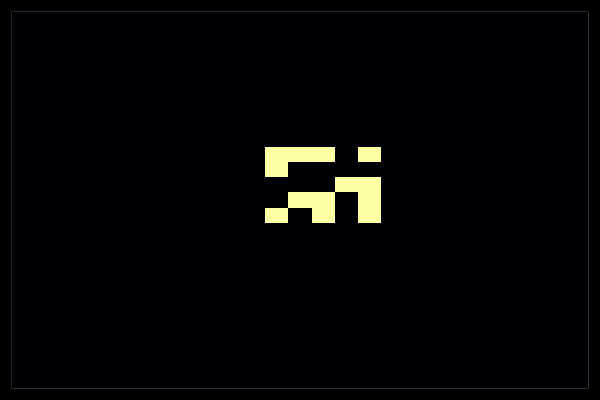

In [9]:
#Lets take an example

N = 25#the size of our grid
num_gens = 100#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our cellular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#the end of the pattern, here 4 is the length and width of the pattern we want to insert
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix

test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL inf pattern1.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original Gol 4 blinkers.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original Gol 4 blinkers.gif")
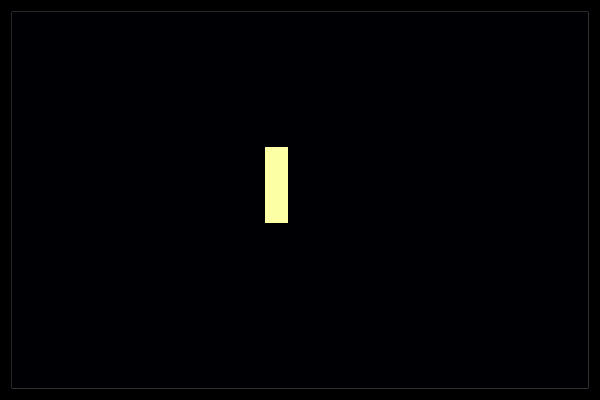

In [8]:
N = 25#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1]
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original Gol 4 blinkers.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original Gol inf pattern2.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original Gol inf pattern2.gif")
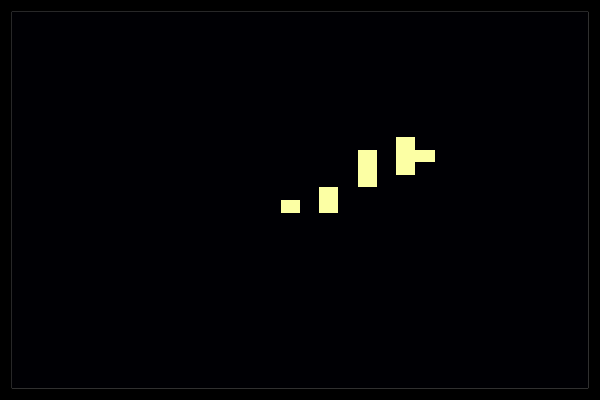

In [13]:
N = 30 #the size of our grid
num_gens = 100 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original Gol inf pattern2.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original Gol inf pattern3.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original Gol inf pattern3.gif")
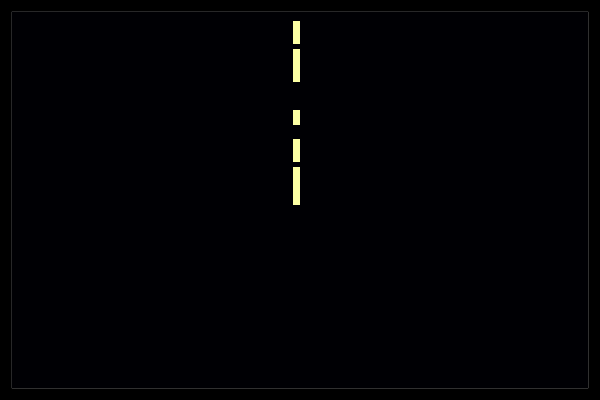

In [36]:
N = 80 #the size of our grid
num_gens = 50 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original Gol inf pattern3.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original GoL beacon.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original GoL beacon.gif")
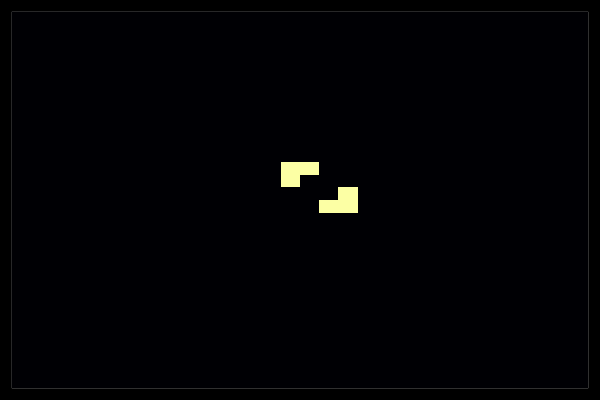

In [37]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL beacon.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original GoL glider.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original GoL glider.gif")
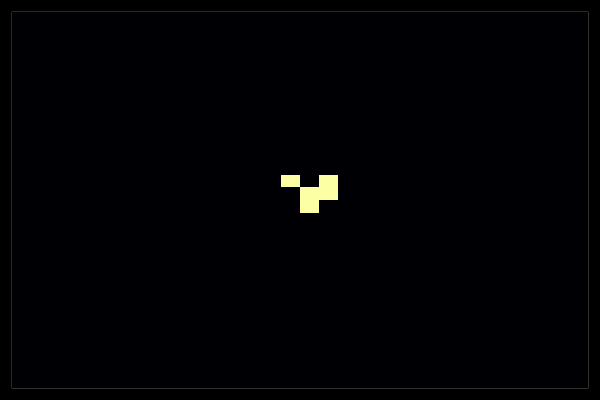

In [38]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;0 1 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL glider.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original GoL LWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original GoL LWSS.gif")
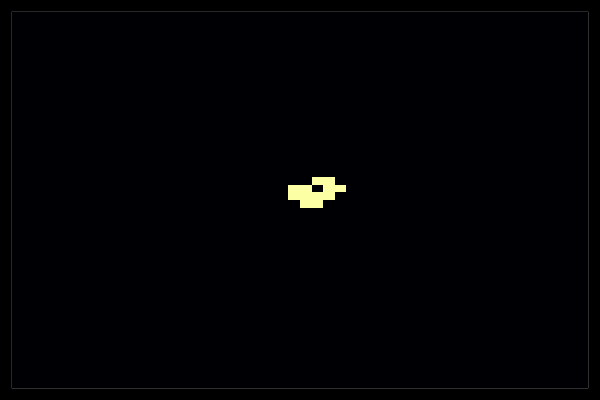

In [42]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL LWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original GoL MWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original GoL MWSS.gif")
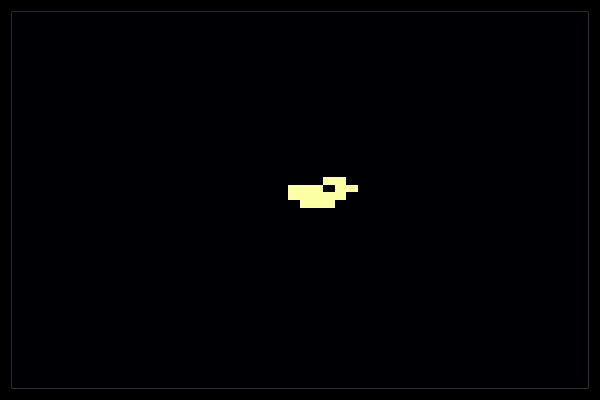

In [40]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL MWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Original GoL HWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Original GoL HWSS.gif")
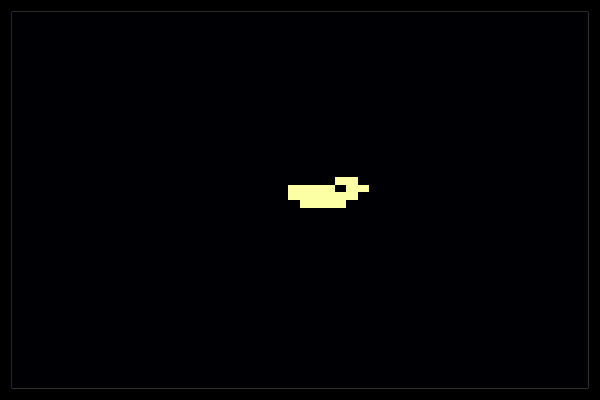

In [43]:
N = 50 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 1 0 0 ;1 1 1 1 1 1 0 ; 1 1 1 1 0 1 1 ; 0 0 0 0 1 1 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update,10)

plot_ca(test1_history,"Original GoL HWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule with inf pattern1.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule with inf pattern1.gif")
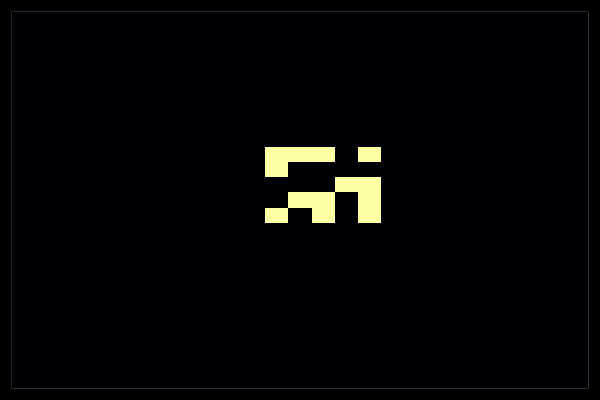

In [6]:
function game_of_life_update_v1(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 0 < alive_neighbors < 3 #if the number of alive_neighbors is equal to 1 or 2, the cell remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors == 3
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end


N = 25#the size of our grid
num_gens = 50#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule with inf pattern1.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule with inf pattern2.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule with inf pattern2.gif")
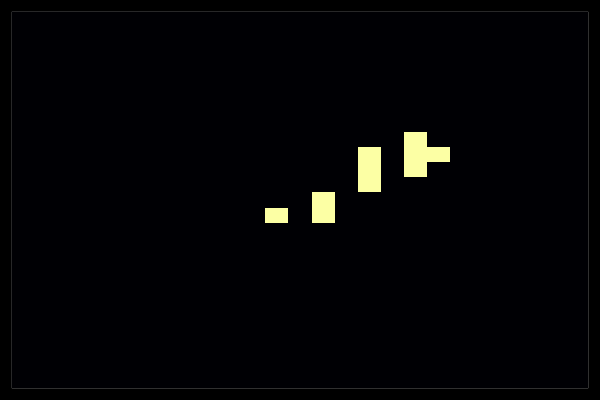

In [12]:
N = 25#the size of our grid
num_gens = 35#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule with inf pattern2.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule inf pattern3.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule inf pattern3.gif")
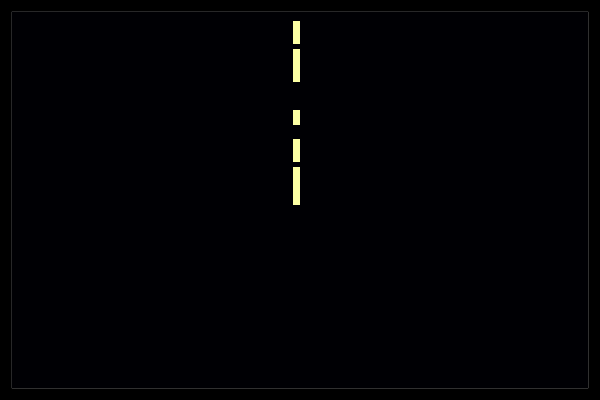

In [14]:
N = 80#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule inf pattern3.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule beacon.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule beacon.gif")
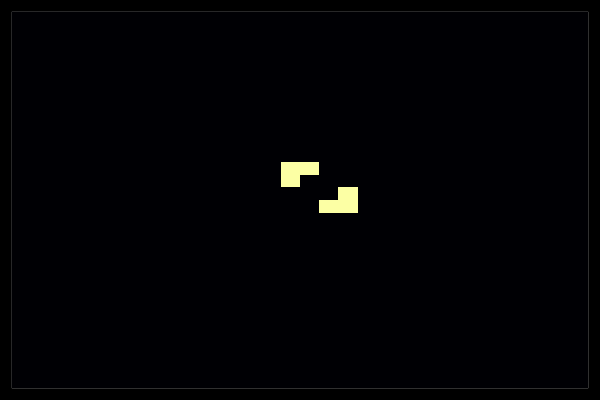

In [16]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule beacon.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule beehive.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule beehive.gif")
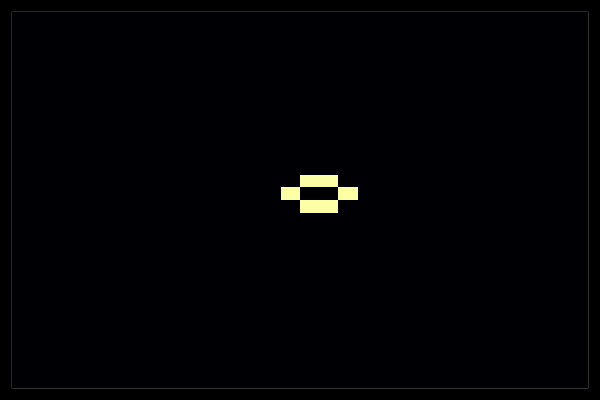

In [17]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 ;1 0 0 1 ; 0 1 1 0; 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule beehive.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule loaf.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule loaf.gif")
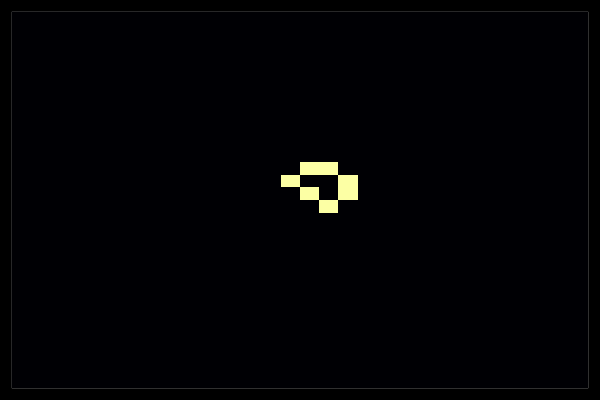

In [18]:
N = 30#the size of our grid
num_gens = 40#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 0 ;0 1 0 1 ; 1 0 0 1; 0 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule loaf.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule boat.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule boat.gif")
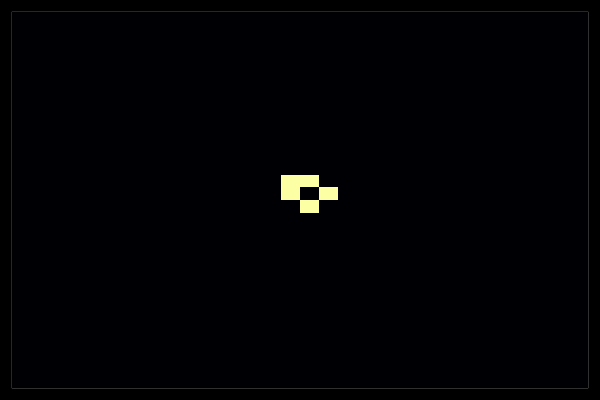

In [19]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 1 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule boat.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule tub.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule tub.gif")
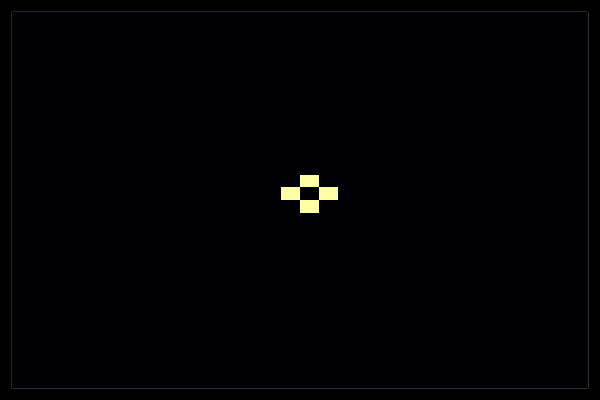

In [20]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule tub.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule blinker.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule blinker.gif")
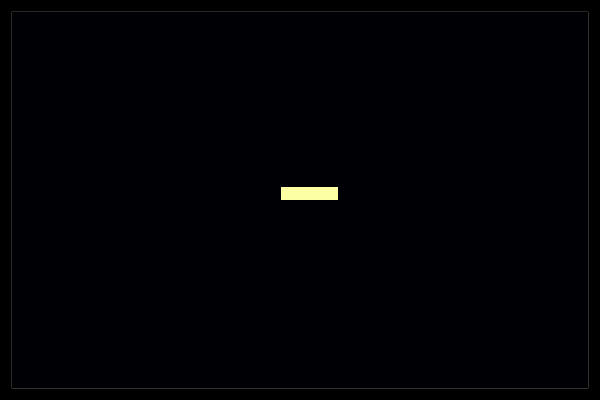

In [21]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 0 ;1 1 1 ; 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule blinker.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\test9.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\test9.gif")
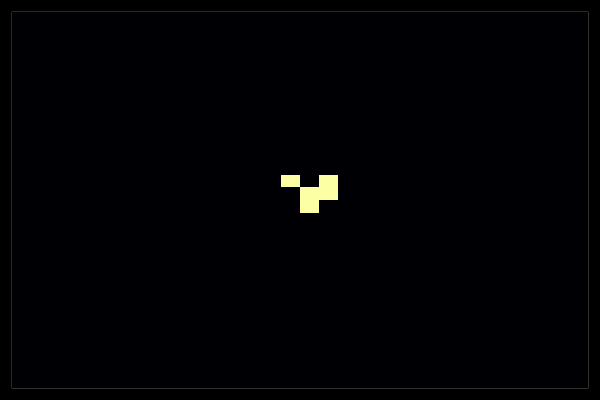

In [39]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;0 1 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\test9.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\test9.gif")
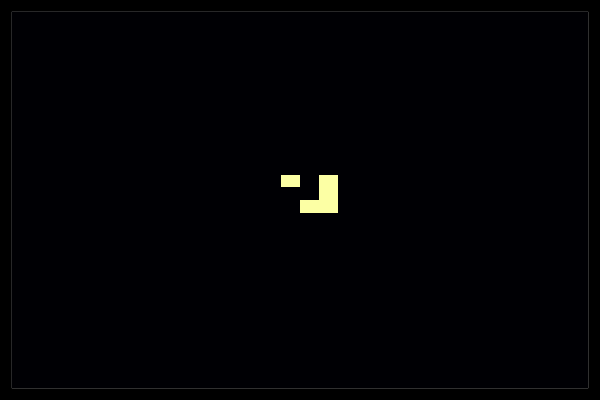

In [40]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 ;0 0 1 ; 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\test9.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\test9.gif")
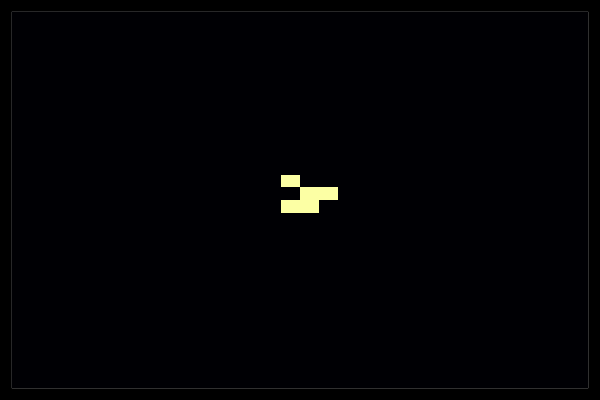

In [41]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 0 ;0 1 1 ; 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\test9.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\test9.gif")
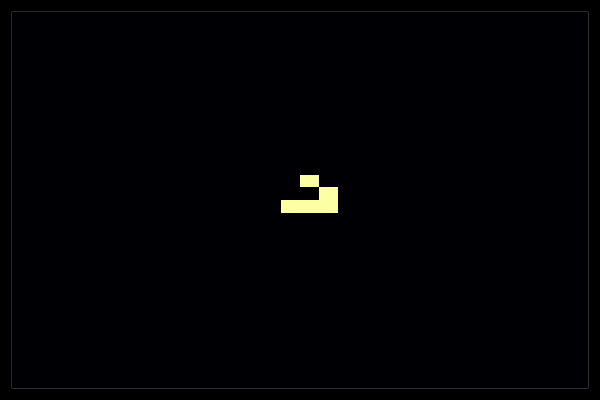

In [45]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 1 ;0 0 1 ; 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"test9.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule LWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule LWSS.gif")
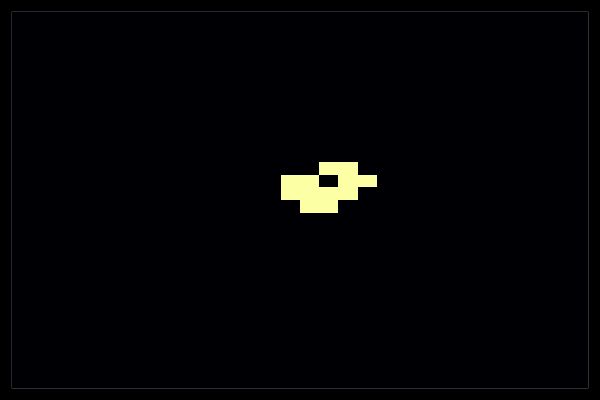

In [22]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule LWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule MWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule MWSS.gif")
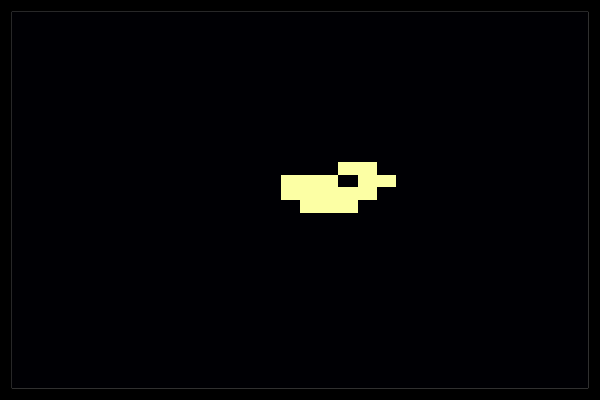

In [23]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule MWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule HWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule HWSS.gif")
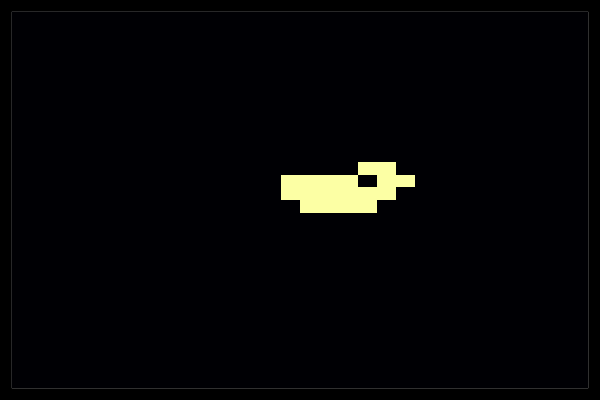

In [26]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 1 0 0 ;1 1 1 1 1 1 0 ; 1 1 1 1 0 1 1 ; 0 0 0 0 1 1 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule HWSS.gif")

In [ ]:
### NEW RULE

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule inf pattern1.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule inf pattern1.gif")
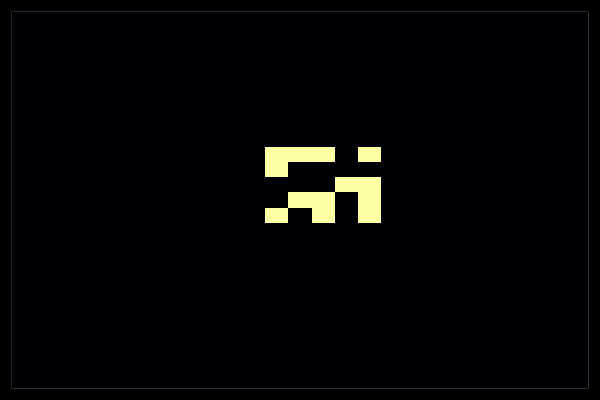

In [5]:
function game_of_life_update_v2(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 2 < alive_neighbors < 5 #if the number of alive_neighbors is equal to 3 or 4, the cell remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors == 3
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end


N = 25#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule inf pattern1.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule inf pattern 2.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule inf pattern 2.gif")
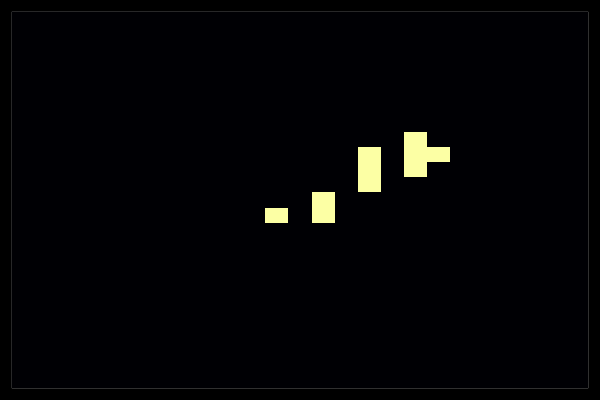

In [28]:
N = 25#the size of our grid
num_gens = 35#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 0 0 0 0 ;0 0 1 0 0 0 0 0 ;0 0 0 0 1 0 0 0 ;0 0 0 0 1 0 1 0 ;0 0 0 0 1 0 1 1 ;0 0 0 0 0 0 1 0 ;0 0 0 0 0 0 0 0 ;0 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule inf pattern 2.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule  inf pattern 3.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule  inf pattern 3.gif")
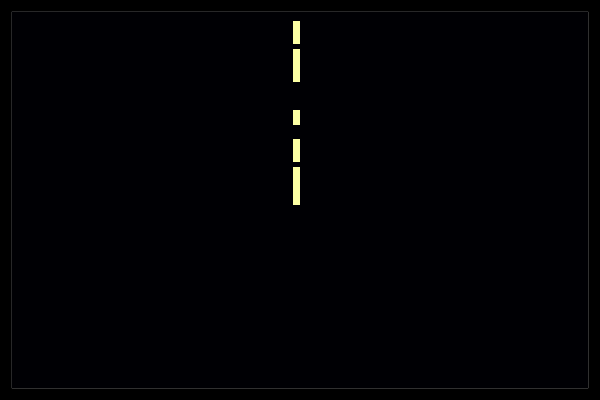

In [29]:
N = 80#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+38#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 ]
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule inf pattern 3.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule beacon.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule beacon.gif")
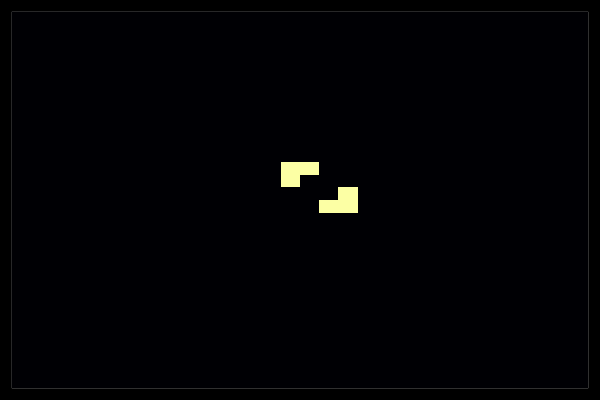

In [30]:
N = 30#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 ; 0 0 0 1 ; 1 0 0 0 ; 1 1 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule beacon.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule loaf.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule loaf.gif")
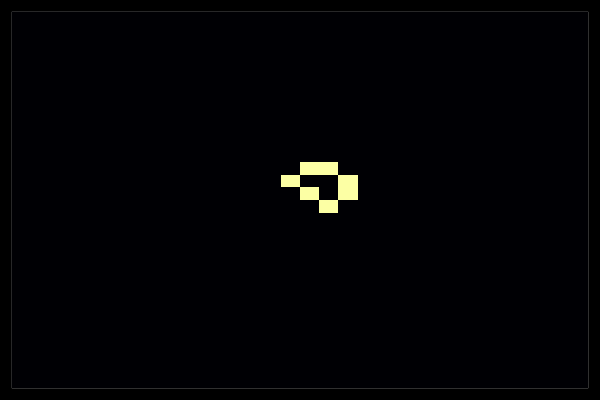

In [31]:
N = 30#the size of our grid
num_gens = 30#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+3 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 0 ;0 1 0 1 ; 1 0 0 1; 0 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule loaf.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule boat.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule boat.gif")
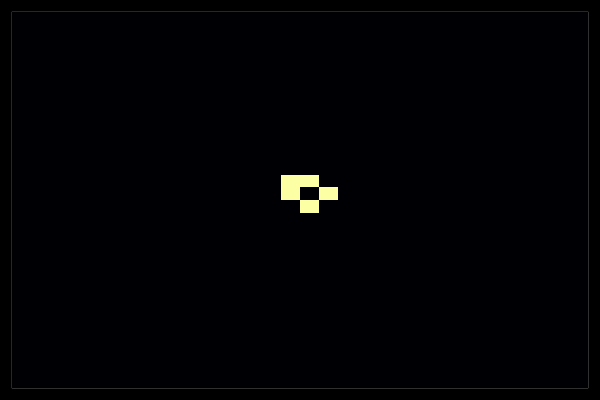

In [32]:
N = 30#the size of our grid
num_gens = 10#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 0 ;1 0 1 ; 1 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule boat.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule LWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule LWSS.gif")
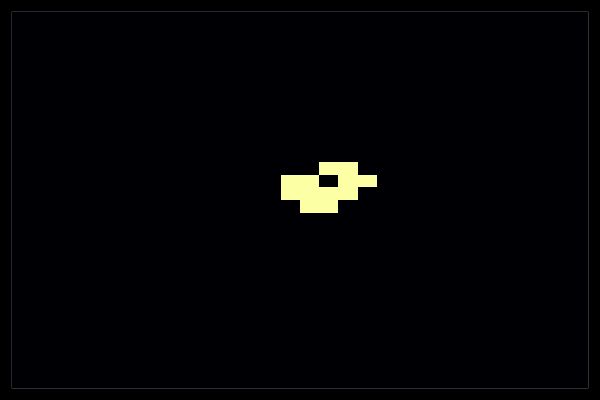

In [33]:
N = 30 #the size of our grid
num_gens = 30 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 ;1 1 1 1 0 ; 1 1 0 1 1 ; 0 0 1 1 0 ; 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule LWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule MWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule MWSS.gif")
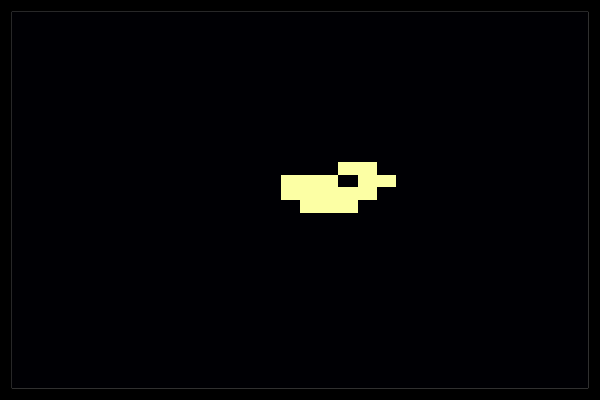

In [34]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 0 0 ;1 1 1 1 1 0 ; 1 1 1 0 1 1 ; 0 0 0 1 1 0 ; 0 0 0 0 0 0 ; 0 0 0 0 0 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule MWSS.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule HWSS.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule HWSS.gif")
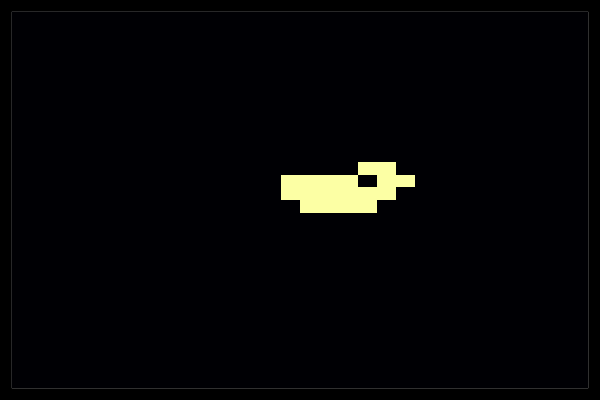

In [35]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 1 1 0 0 ;1 1 1 1 1 1 0 ; 1 1 1 1 0 1 1 ; 0 0 0 0 1 1 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ; 0 0 0 0 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule HWSS.gif")

In [ ]:
### trying to find new structures in Alt1 rule

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule square with gaps.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule square with gaps.gif")
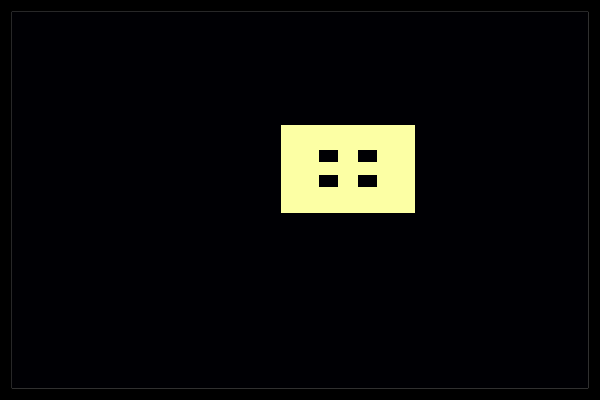

In [53]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 1 1 1 1 1 ; 1 1 1 1 1 1 1 ; 1 1 0 1 0 1 1 ; 1 1 1 1 1 1 1 ; 1 1 0 1 0 1 1 ; 1 1 1 1 1 1 1 ; 1 1 1 1 1 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule square with gaps.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule 4 lines.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule 4 lines.gif")
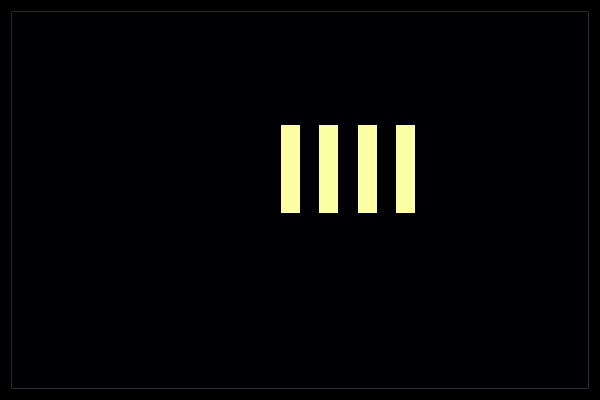

In [61]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule 4 lines.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule checker.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule checker.gif")
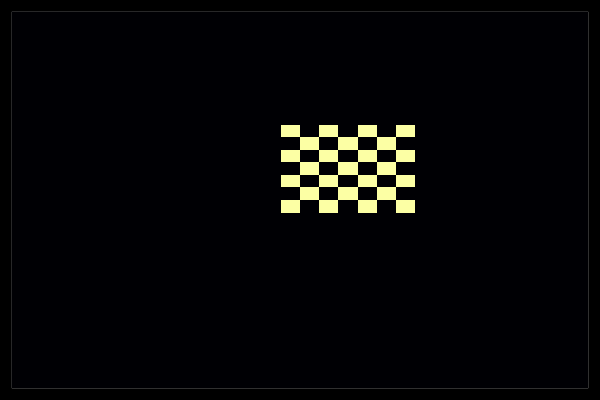

In [64]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule checker.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule staggered checker.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule staggered checker.gif")
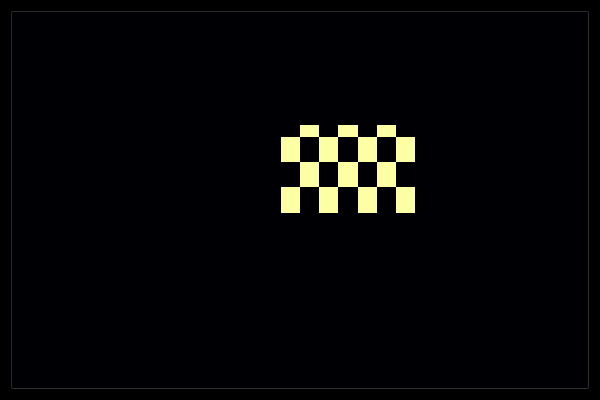

In [75]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ; 0 1 0 1 0 1 0 ; 1 0 1 0 1 0 1 ; 1 0 1 0 1 0 1 ; 0 1 0 1 0 1 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule staggered checker.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule random1.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule random1.gif")
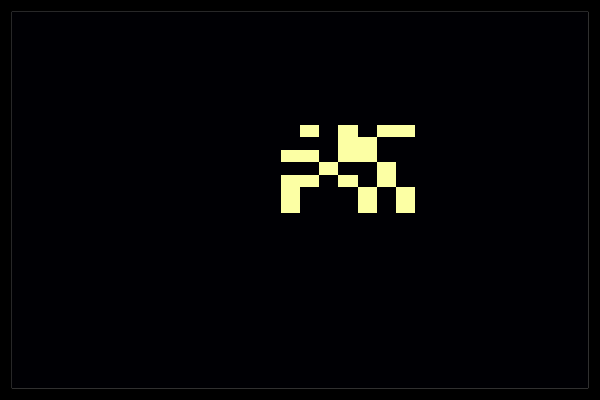

In [80]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 0 0 0 1 0 1 ; 1 0 0 0 1 0 1 ; 1 1 0 1 0 1 0 ; 0 0 1 0 0 1 0 ; 1 1 0 1 1 0 0 ; 0 0 0 1 1 0 0 ; 0 1 0 1 0 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random1.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule random2.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule random2.gif")
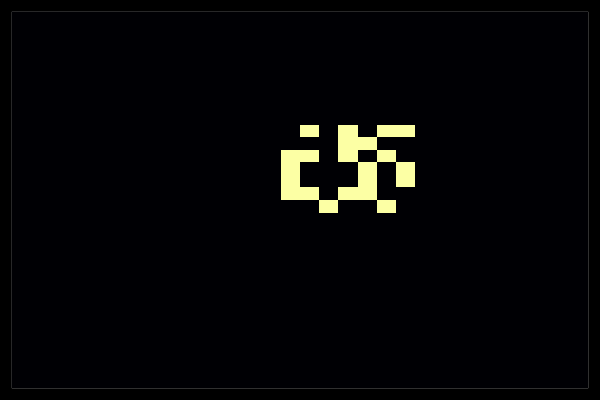

In [82]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 0 0 1 0 ; 1 1 0 1 1 0 0 ; 1 0 0 0 1 0 1 ; 1 0 0 0 1 0 1 ; 1 1 0 1 0 1 0 ;0 0 0 1 1 0 0 ; 0 1 0 1 0 1 1 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random2.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\yeah.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\yeah.gif")
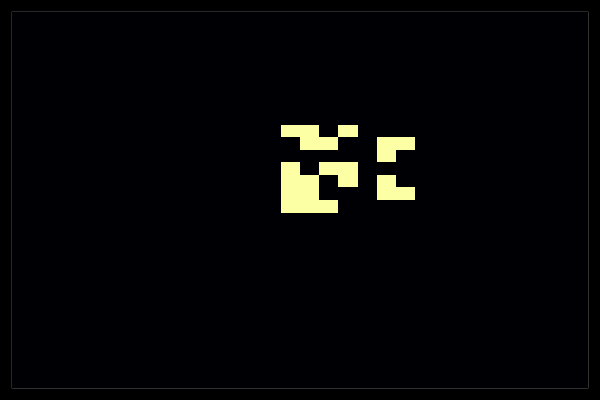

In [95]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 1 1 1 0 0 0 0 ; 1 1 0 0 0 1 1 ; 1 1 0 1 0 1 0 ; 1 0 1 1 0 0 0 ; 0 0 0 0 0 1 0 ; 0 1 1 0 0 1 1 ; 1 1 0 1 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random3.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt1 rule random4.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt1 rule random4.gif")
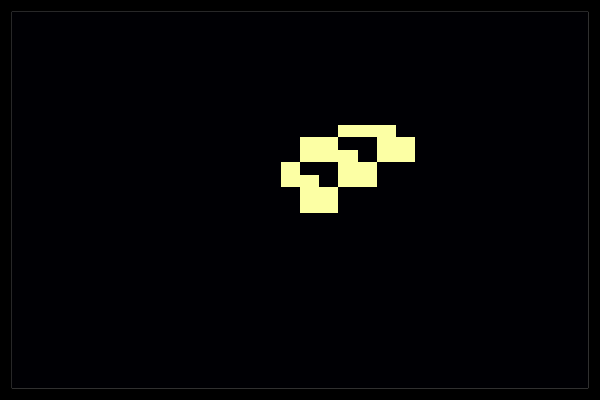

In [99]:
N = 30 #the size of our grid
num_gens = 40 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 1 1 0 0 0 0 ;0 1 1 0 0 0 0 ;1 1 0 1 1 0 0 ;1 0 0 1 1 0 0 ;0 1 1 1 0 1 1 ;0 1 1 0 0 1 1 ;0 0 0 1 1 1 0]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v1,10)

plot_ca(test1_history,"Alt1 rule random4.gif")

In [ ]:
### trying to find new structures in Alt2 rule

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule random1 period 16.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule random1 period 16.gif")
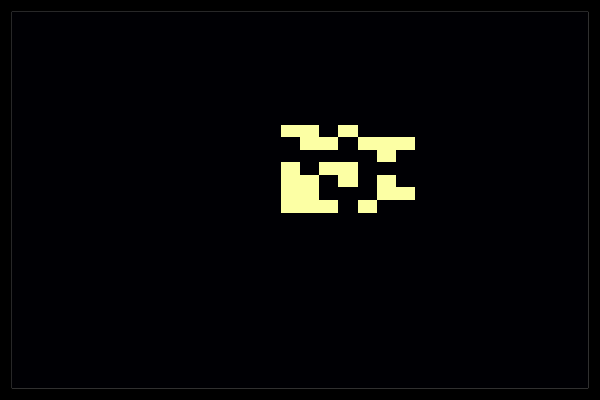

In [9]:
N = 30 #the size of our grid
num_gens = 50 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 1 1 1 0 1 0 0 ; 1 1 0 0 0 1 1 ; 1 1 0 1 0 1 0 ; 1 0 1 1 0 0 0 ; 0 0 0 0 0 1 0 ; 0 1 1 0 1 1 1 ; 1 1 0 1 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule random1 period 16.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule period 16.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule period 16.gif")
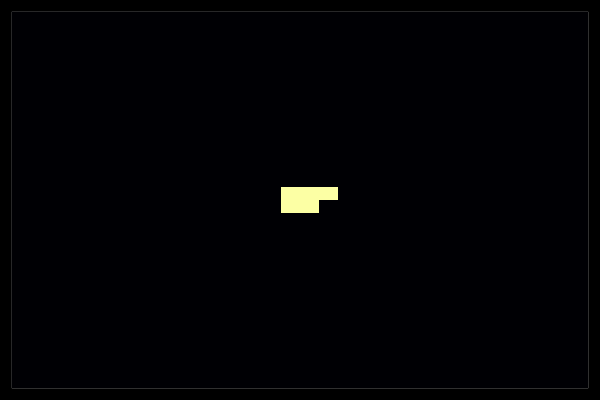

In [21]:
N = 30#the size of our grid
num_gens = 17#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+2 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [1 1 0 ;1 1 1 ; 0 0 0 ]#take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule period 16.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule 4 period 16.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule 4 period 16.gif")
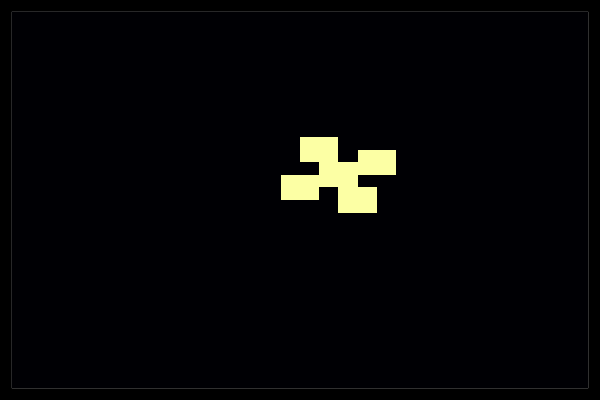

In [14]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 0 1 1 0 ; 1 1 0 1 1 0 ; 1 1 1 1 0 0 ; 0 0 1 1 1 1 ; 0 1 1 0 1 1 ;0 1 1 0 0 0 ] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule ls square.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule ls square.gif")
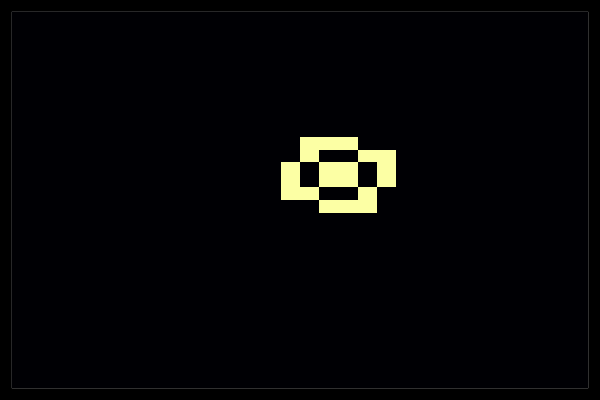

In [17]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+5 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [0 0 1 1 1 0 ; 1 1 0 0 1 0 ; 1 0 1 1 0 1 ; 1 0 1 1 0 1 ; 0 1 0 0 1 1 ;0 1 1 1 0 0 ] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule ls square.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule 4 period 16 take2.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule 4 period 16 take2.gif")
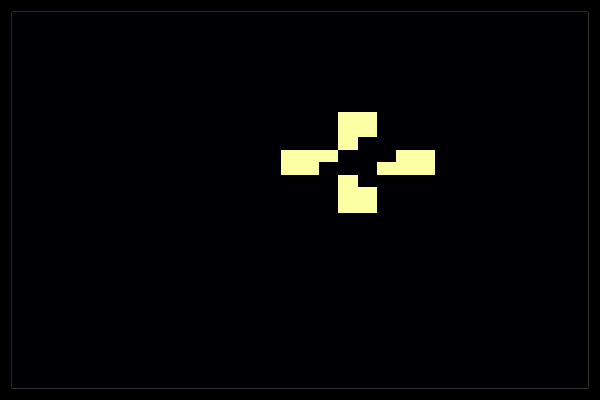

In [40]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 0 1 1 0 0 0;0 0 0 1 1 0 0 0 ;0 0 0 1 0 0 0 0 ;1 1 0 0 0 1 1 1; 1 1 1 0 0 0 1 1; 0 0 0 1 0 0 0 0; 0 0 0 1 1 0 0 0; 0 0 0 1 1 0 0 0] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16 take2.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule 4 period 16 take3.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule 4 period 16 take3.gif")
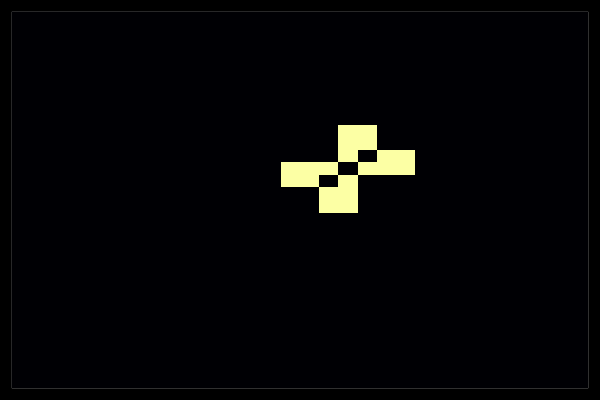

In [43]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+6 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 1 1 0 0 0; 0 0 1 1 0 0 0 ; 1 1 0 1 0 0 0 ; 1 1 1 0 1 1 1 ; 0 0 0 1 0 1 1; 0 0 0 1 1 0 0; 0 0 0 1 1 0 0] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16 take3.gif")

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\MOCS\Mini project- assn 2\Alt2 rule 4 period 16 take4.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\MOCS\\Mini project- assn 2\\Alt2 rule 4 period 16 take4.gif")
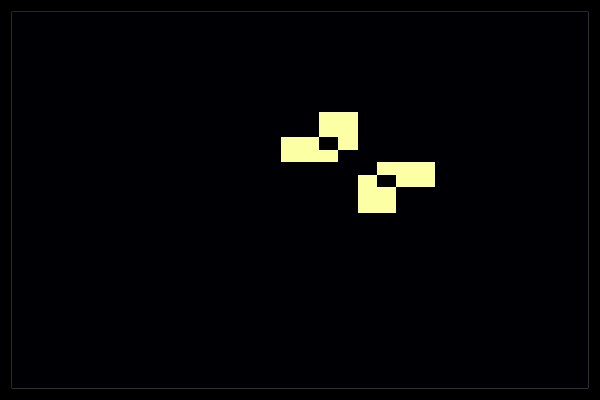

In [55]:
N = 30 #the size of our grid
num_gens = 20 #number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#


#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2) #the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+7 #here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin:init_end] = [ 0 0 0 0 1 1 0 0; 0 0 0 0 1 1 0 0 ; 0 0 0 0 1 0 1 1 ; 0 0 0 0 0 1 1 1 ; 1 1 1 0 0 0 0 0 ; 1 1 0 1 0 0 0 0; 0 0 1 1 0 0 0 0 ; 0 0 1 1 0 0 0 0] #take a 2d slice of the array that goes from <init_begin> to <init_end> in both the x and y directions, replace it with a given matrix
test1_history = run_ca_simulation(grid,game_of_life_update_v2,10)

plot_ca(test1_history,"Alt2 rule 4 period 16 take4.gif")

In [11]:
### The next version is varying how many alive cells need to be around a dead cell for one to be flipped on


In [ ]:
'''function game_of_life_update_v3(neighborhood)
    """
    Given an array of values of the neighborhood of a cell, calculate the updated value of the cell according to Conway's Game of life: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
    inputs:
        neighborhood<matrix> a matrix of the neighborhood around a cell
    returns: 
        return_condition<int>: the conidition of the updated cell at index i,j, 0 if dead, 1 if alive
    """
    my_cell = neighborhood[2,2]
    return_condition = 0#the state of the current cell to reuturn from this function

    #if the cell is alive
    if my_cell == 1
        alive_neighbors = sum(neighborhood)-1#the number of neighbors who are alive_neighborohood, subtract one to account for the cell itself.
        #determine status of current cell based on status of neighboring cells
        if 1 < alive_neighbors < 4 #if the number of alive_neighbors is equal to 2 or 3, the cell remains alive
            return_condition = 1
        end
    end
    #if cell is dead 
    if my_cell == 0
        alive_neighbors = sum(neighborhood)
        if alive_neighbors >=2 
            return_condition = 1
        end
    end
    
#println(return_condition)
return return_condition
end


N = 100#the size of our grid
num_gens = 100#number of generations to run 


grid = zeros(Int8,N,N)#instantiate a N,N matrix filled with 0s, this will be the inital state of our celluular automata
#grid_history = zeros(Int8,N,N,num_gens)#

#now lets use list slicing to insert a pattern in the middle of the grid
init_begin = (N ÷ 2)#the pattern begins at the exact middle of the grid, note that the "÷", is floor division in Julia, it take the result of the division and rounds it down to the nearest integer
init_end = init_begin+4#here is where things diverge from above, we want a line of 5 pixels, they will go from the middle of our grid to 4 pixels after the middle, for a total of 5 pixels. 

"""this is the trickier part - we want a line so we want to grab the x elements of our grid between the middle of the grid(<init_begin>) and 4 blocks to the left of the middle<init_end>. this is the first part of the slice 
init_begin:init_end,this is the x coordinates of our slice. For the y, we just want a single row, so we will will just index it as <init_begin>

"""
grid[init_begin:init_end,init_begin] = [1 1 1 1 1]
test1_history = run_ca_simulation(grid,game_of_life_update_v3,10)

plot_ca(test1_history,"test1.gif")'''

In [16]:
N = 25#size of space
num_gens = 100#number of generations to run 


grid = zeros(Int8,N,N)

grid_history = zeros(Int8,N,N,num_gens)

values = [mod1.(x .+ [-1,0,1], size(grid)[1]) for x in 1:length(grid)]

init_end = (N ÷ 2)+4
grid[N÷2:init_end,N÷2:init_end] = [1 0 1 0 1;0 1 1 0 1; 0 0 0 1 1;1 0 0 0 0;1 1 1 0 1]
grid_history[:,:,1] = grid

for gen in 2:num_gens
    next_grid =zeros(Int8,N,N) 
    for (i,j) in Tuple.(CartesianIndices(grid))
        #println("$i,$j")
        neighborhood = get_von_neumann_neighbors(i,j,grid)
        #println(neighborhood)
        next_grid[i,j] = game_of_life_update(neighborhood)
    end
    grid_history[:,:,gen] = next_grid
    grid = next_grid

    
end

LoadError: UndefKeywordError: keyword argument dims not assigned

┌ Info: Saved animation to 
│   fn = C:\Users\ontiv\anaconda3\Adam's_Scripts\test.gif
└ @ Plots C:\Users\ontiv\.julia\packages\Plots\AAjgN\src\animation.jl:139


Plots.AnimatedGif("C:\\Users\\ontiv\\anaconda3\\Adam's_Scripts\\test.gif")
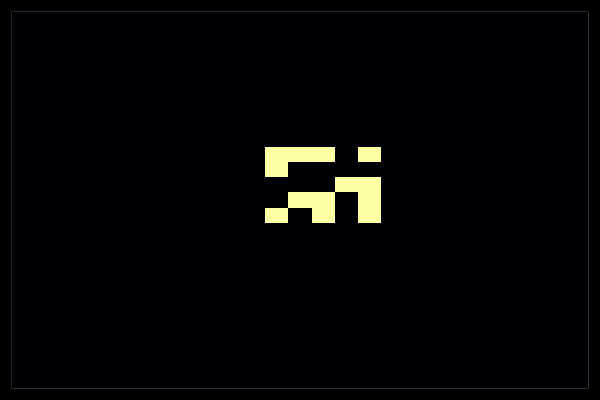

In [33]:
plot_ca(grid_history,"test.gif")


In [ ]:
#anim = @animate for frame in 1:num_gens
anim = @animate for frame in 1:num_gens
    heatmap(grid_history[:,:,frame],xaxis = false,yaxis=false,legend = false,ticks=false,background_color_outside = "black",figsize = (15,15))
end
gif(anim,"test.gif",fps=10)